In [1]:
# Add the relevant scripts from LArMachineLearningData
# Nice the process so it can run with lots of cores on low priority
import os
os.nice(20)

# Add local paths
import sys
hnlDIR = os.environ['_']
sys.path.append('../pyscript')

# From pyscript Library
from Plotting import *
from Dictionary import *
from HelperFunctions import *
from CutFunctions import *
from SystematicsHelpers import *

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

import warnings
warnings.filterwarnings("ignore")

import pyhf
from pyhf.contrib.viz import brazil

pyhf.set_backend("numpy")

Welcome to JupyROOT 6.24/06


In [2]:
savePath = "../plot_files/Sensistivity/"

<h1> Read in HNL Dictionary </h1>

In [28]:
#suffix = '_1ns_bin'
#suffix = '_merged_bins'
#suffix = '_merged_bins_aggressive'

#suffix = '_merged_bins_peak_edge'

#suffix = '_merged_bins_peak_edge_aggressive'
#suffix = '_1ns_bin_peak_edge_aggressive'

#suffix = '_merged_bins_peak_edge_adjust'
#suffix = '_1ns_bin_peak_edge_adjust'

suffix = '_merged_bins_peak_edge_final'

In [29]:
nu_dict = np.load("../pkl_files/v3_April2024/nu_v3_dict"+suffix+".npy",allow_pickle='TRUE').item()

In [30]:
cos_dict = np.load("../pkl_files/v3_April2024/cos_v3_dict"+suffix+".npy",allow_pickle='TRUE').item()

In [31]:
bkg_dict = np.load("../pkl_files/v3_April2024/bkg_v3_dict"+suffix+".npy",allow_pickle='TRUE').item()

In [32]:
hnl_dict = {}
mass_list = [140, 160, 180, 200, 220, 240]

for m in mass_list:
    hnl_dict[m] = np.load("../pkl_files/v3_April2024/hnl_m"+str(m)+"_v3_dict"+suffix+".npy",allow_pickle='TRUE').item()

In [33]:
def slice_first_last_n_bins(n, array):
    return (array[:n] + array[-n:])

def fill_middle_bins_zero(array):
    replace_idx = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    new_array = [0 if idx in replace_idx else item for idx,item in  enumerate(array)]
    return new_array

def fill_edge_bins_zero(array):
    replace_idx = [0, 1, 2, 11, 12, 13]
    new_array = [0 if idx in replace_idx else item for idx,item in  enumerate(array)]
    return new_array

def inflate_signal(array):
    replace_idx = [0, 1, 2, 11, 12, 13]
    new_array = [item*1.2 if idx in replace_idx else item for idx,item in  enumerate(array)]
    return new_array

def less_signal(array):
    replace_idx = [0, 1, 2, 11, 12, 13]
    new_array = [item*0.5 if idx in replace_idx else item for idx,item in  enumerate(array)]
    return new_array

<h1>Sanity Plot</h1>

In [36]:
def sanity_plot(m):
    
    #bins = np.arange(0, 20, 1)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))

    #-----------------------------------------------------------------#
    ax1.step(bins, np.insert(hnl_dict[m]['signal'], 0, 0)
             , color = hnl_col
             , label =  "Signal"
    )

    #-----------------------------------------------------------------#
    ax2.step(bins, np.insert(bkg_dict['bkg'], 0, 0)
             , color = nu_col
             , label =  "Neutrino + Cosmic Background"
    )
    #-----------------------------------------------------------------#
    ax1.legend(loc = 'upper left',fontsize = 14)

    plot_tick(ax1, 16)
    plot_title(ax1, "", 'Opt0 Time Corrected Z % 18.936 [ns]',  r"Slices (1$\times10^{21}$ POT)", 16)

    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(0, 100)
    #-----------------------------------------------------------------#
    ax2.legend(loc = 'upper left',fontsize = 14)

    plot_tick(ax2, 16)
    plot_title(ax2, "", 'Opt0 Time Corrected Z % 18.936 [ns]',  r"Slices (1$\times10^{21}$ POT)", 16)

    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(0, 2200)

    #-----------------------------------------------------------------#
    fig.tight_layout()

    plt.show()

140


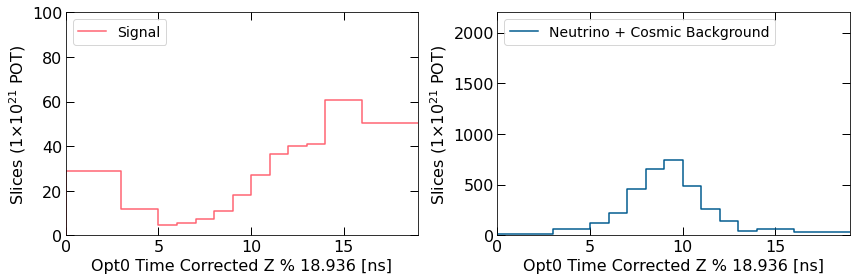

160


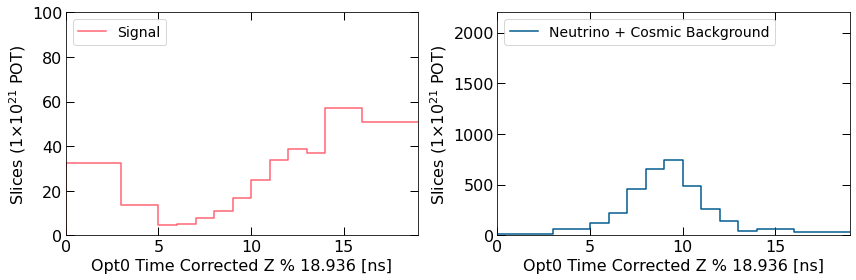

180


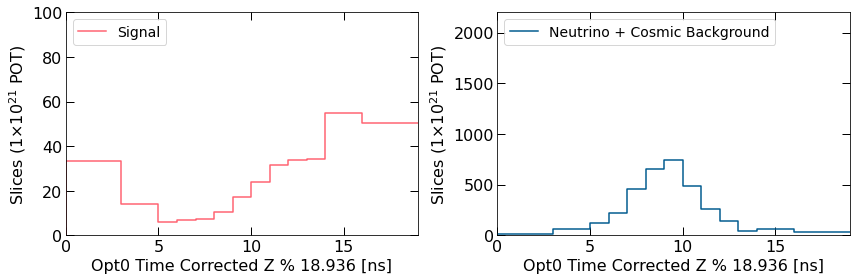

200


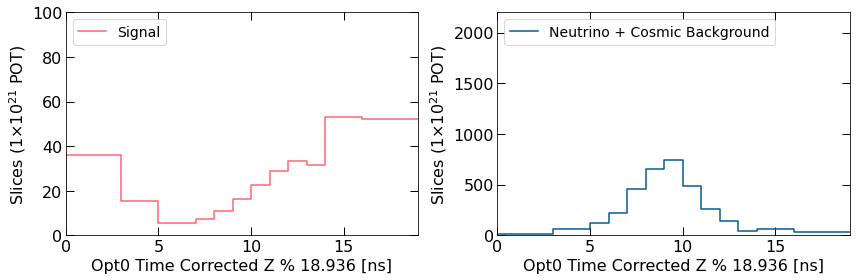

220


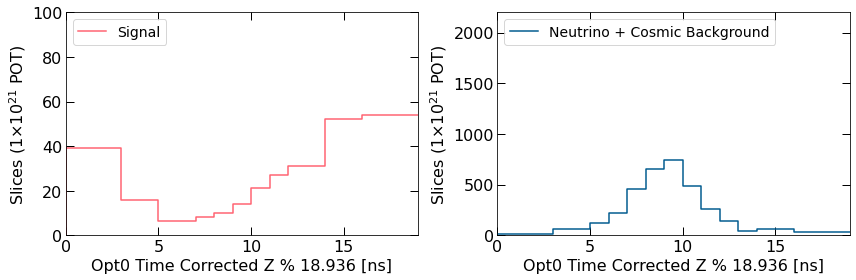

240


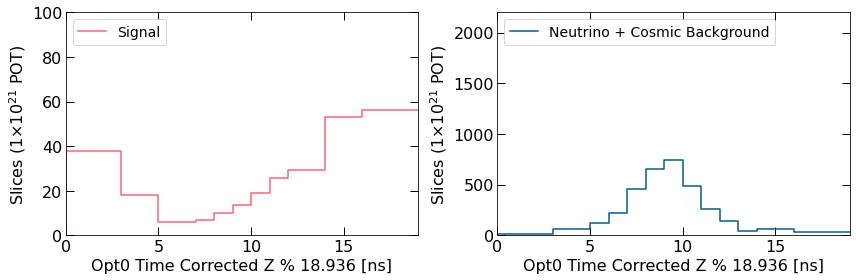

In [37]:
for m in mass_list:
    print(m)
    sanity_plot(m)

<h1>Define Models</h1>

In [38]:
def make_model_stat_cosmics(m):
    model = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": hnl_dict[m]['signal'],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "signal_stat", "type": "shapesys", "data": hnl_dict[m]['stat_err'] },
                {"name": "signal_cosmic", "type": "shapesys", "data": hnl_dict[m]['mistagging_err'] },
              ]
            },
            {
              "name": "background",
              "data": bkg_dict['bkg'],
              "modifiers": [
                {"name": "bkg_stat", "type": "shapesys", "data": bkg_dict['stat_err']},
              ]
            }
          ]
        }
      ]
    }
    )

    print(f'Samples:\n {model.config.samples}')
    print(f'Modifiers are:\n {model.config.modifiers}')

    data = bkg_dict['bkg'] + model.config.auxdata
    
    return model, data

In [39]:
def make_model_full_systematics(m):
    #signal flx
    signal_flx_lo = np.array(hnl_dict[m]['signal']) - np.array(hnl_dict[m]['flx_err'])
    signal_flx_lo = signal_flx_lo.tolist()
    
    signal_flx_hi = np.array(hnl_dict[m]['signal']) + np.array(hnl_dict[m]['flx_err'])
    signal_flx_hi = signal_flx_hi.tolist()
    
    #bkg flx
    bkg_flx_lo = np.array(bkg_dict['bkg']) - np.array(bkg_dict['flx_err'])
    bkg_flx_lo = bkg_flx_lo.tolist()
    
    bkg_flx_hi = np.array(bkg_dict['bkg']) + np.array(bkg_dict['flx_err'])
    bkg_flx_hi = bkg_flx_hi.tolist()
    
    #bkg xsec
    bkg_xsec_lo = np.array(bkg_dict['bkg']) - np.array(bkg_dict['xsec_err'])
    bkg_xsec_lo = bkg_xsec_lo.tolist()
    
    bkg_xsec_hi = np.array(bkg_dict['bkg']) + np.array(bkg_dict['xsec_err'])
    bkg_xsec_hi = bkg_xsec_hi.tolist()
    
    #g4 xsec
    bkg_g4_lo = np.array(bkg_dict['bkg']) - np.array(bkg_dict['g4_err'])
    bkg_g4_lo = bkg_g4_lo.tolist()
    
    bkg_g4_hi = np.array(bkg_dict['bkg']) + np.array(bkg_dict['g4_err'])
    bkg_g4_hi = bkg_g4_hi.tolist()    
    
    model = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": hnl_dict[m]['signal'],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "signal_stat", "type": "staterror", "data": hnl_dict[m]['stat_err'] },
                {"name": "signal_cosmic", "type": "shapesys", "data": hnl_dict[m]['mistagging_err'] },
                {"name": "signal_flx", "type": "histosys", "data": {"lo_data": signal_flx_lo, "hi_data": signal_flx_hi} },
              ]
            },
            {
              "name": "background",
              "data": bkg_dict['bkg'],
              "modifiers": [
                {"name": "bkg_stat", "type": "staterror", "data": bkg_dict['stat_err']},
                {"name": "bkg_flx", "type": "histosys", "data": {"lo_data": bkg_flx_lo, "hi_data": bkg_flx_hi} },
                {"name": "bkg_xsec", "type": "histosys", "data": {"lo_data": bkg_xsec_lo, "hi_data": bkg_xsec_hi} },
                {"name": "bkg_g4", "type": "histosys", "data": {"lo_data": bkg_g4_lo, "hi_data": bkg_g4_hi} },
              ]
            }
          ]
        }
      ]
    }
    )

    print(f'Samples:\n {model.config.samples}')
    print(f'Modifiers are:\n {model.config.modifiers}')

    data = bkg_dict['bkg'] + model.config.auxdata
    
    return model, data

<h1>Perform Fit</h1>

In [40]:
for m in mass_list:
    model, data = make_model_stat_cosmics(m)
    #model, data = make_model_full_systematics(m)
    hnl_dict[m]['model'] = model
    hnl_dict[m]['data'] = data

Samples:
 ['background', 'signal']
Modifiers are:
 [('bkg_stat', 'shapesys'), ('mu', 'normfactor'), ('signal_cosmic', 'shapesys'), ('signal_stat', 'shapesys')]
Samples:
 ['background', 'signal']
Modifiers are:
 [('bkg_stat', 'shapesys'), ('mu', 'normfactor'), ('signal_cosmic', 'shapesys'), ('signal_stat', 'shapesys')]
Samples:
 ['background', 'signal']
Modifiers are:
 [('bkg_stat', 'shapesys'), ('mu', 'normfactor'), ('signal_cosmic', 'shapesys'), ('signal_stat', 'shapesys')]
Samples:
 ['background', 'signal']
Modifiers are:
 [('bkg_stat', 'shapesys'), ('mu', 'normfactor'), ('signal_cosmic', 'shapesys'), ('signal_stat', 'shapesys')]
Samples:
 ['background', 'signal']
Modifiers are:
 [('bkg_stat', 'shapesys'), ('mu', 'normfactor'), ('signal_cosmic', 'shapesys'), ('signal_stat', 'shapesys')]
Samples:
 ['background', 'signal']
Modifiers are:
 [('bkg_stat', 'shapesys'), ('mu', 'normfactor'), ('signal_cosmic', 'shapesys'), ('signal_stat', 'shapesys')]


In [41]:
poi_vals = np.linspace(0, 1, 100)
#poi_vals = np.linspace(0, 0.1, 50)

for m in mass_list:
    obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
                                                                                        hnl_dict[m]['data'], 
                                                                                        hnl_dict[m]['model'], 
                                                                                        poi_vals, 
                                                                                        level=0.1, 
                                                                                        return_results=True,
                                                                                        test_stat='qtilde')
    
    hnl_dict[m]['u_exp_bands'] = exp_limits_single

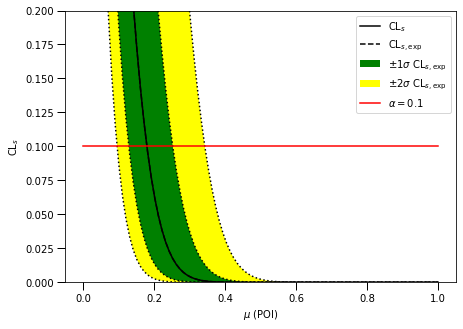

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
brazil.plot_results(poi_vals, results, ax=ax, test_size=0.10,)
plt.ylim(0.0,0.2)
fig.show()

In [43]:
neg2_list = []
neg1_list = []
mean_list = []
pos1_list = []
pos2_list = []

for m in mass_list:
    neg2_list.append(np.sqrt(hnl_dict[m]['u_exp_bands'][0]) * hnl_dict[m]['U'])
    neg1_list.append(np.sqrt(hnl_dict[m]['u_exp_bands'][1]) * hnl_dict[m]['U'])
    mean_list.append(np.sqrt(hnl_dict[m]['u_exp_bands'][2]) * hnl_dict[m]['U'])
    pos1_list.append(np.sqrt(hnl_dict[m]['u_exp_bands'][3]) * hnl_dict[m]['U'])
    pos2_list.append(np.sqrt(hnl_dict[m]['u_exp_bands'][4]) * hnl_dict[m]['U'])
    
neg2_list = np.array(neg2_list)
neg1_list = np.array(neg1_list)
mean_list = np.array(mean_list)
pos1_list = np.array(pos1_list)
pos2_list = np.array(pos2_list)

<h1>Plot</h1>

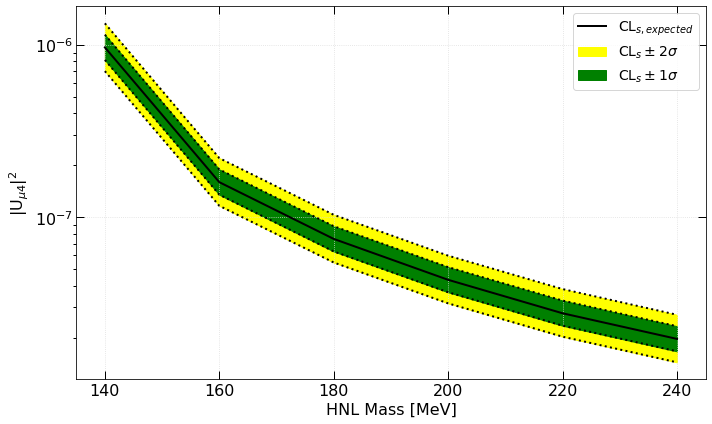

In [44]:
fig, ax1 = plt.subplots(1,1, figsize=(10,6))

xlimmin = 140
xlimmax = 240

plt.grid(axis = 'both', color='gainsboro', linestyle = ":")
#-------------------------------------------------------------------
ax1.plot(mass_list, neg2_list, lw = 2, ls = ':', c='k')
ax1.plot(mass_list, neg1_list, lw = 2, ls = ':', c='k')
ax1.plot(mass_list, mean_list, lw = 2, ls = '-', c='k', label=r'CL$_{s, expected}$')
ax1.plot(mass_list, pos1_list, lw = 2, ls = ':', c='k')
ax1.plot(mass_list, pos2_list, lw = 2, ls = ':', c='k')
#-------------------------------------------------------------------

ax1.fill_between(mass_list, neg2_list, pos2_list, color='yellow', label = r'CL$_{s} \pm 2 \sigma$')
ax1.fill_between(mass_list, neg1_list, pos1_list, color='green', label = r'CL$_{s} \pm 1 \sigma$')
#-------------------------------------------------------------------

ax1.set_yscale('log')

ax1.legend(loc="upper right", fontsize =14)

plot_tick(ax1, 16)
plot_title(ax1, "", "HNL Mass [MeV]",  "|U$_{\mu4}$|$^2$", 16)

#-------------------------------------------------------------------
fig.tight_layout()
#plt.savefig(savePath+str("sensitivity_"+suffix+".png"), dpi=200)
plt.show()

<h1>Save to CVS file</h1>

In [45]:
suffix = suffix #+ '_fit_edge_only'
file_name = "../PrettyPlots_notebook/contour/stats_only_limits"+suffix+".txt"

f = open(file_name, "w")

f.write("m -2sig -1sig 0sig +1sig +2sig \n")

for m in mass_list:
    
    string = ""
    string = string + str(m) + " "
    string = string + str(np.sqrt(hnl_dict[m]['u_exp_bands'][0]) * hnl_dict[m]['U']) + " "
    string = string + str(np.sqrt(hnl_dict[m]['u_exp_bands'][1]) * hnl_dict[m]['U']) + " "
    string = string + str(np.sqrt(hnl_dict[m]['u_exp_bands'][2]) * hnl_dict[m]['U']) + " "
    string = string + str(np.sqrt(hnl_dict[m]['u_exp_bands'][3]) * hnl_dict[m]['U']) + " "
    string = string + str(np.sqrt(hnl_dict[m]['u_exp_bands'][4]) * hnl_dict[m]['U']) + "\n"
    
    print(string)
    
    f.write(string)
    
f.close()

140 7.029018549934329e-07 8.161696865400385e-07 9.653863025395625e-07 1.1446845156997592e-06 1.3308749710134424e-06

160 1.1636249485230993e-07 1.349161502593028e-07 1.5956035433551814e-07 1.8912180758781144e-07 2.2008292305212015e-07

180 5.458235640543154e-08 6.32609697045722e-08 7.479071861525393e-08 8.86403946412968e-08 1.0319865545095674e-07

200 3.1617791938314844e-08 3.667025201891092e-08 4.3309162576111556e-08 5.1313595670465725e-08 5.980368830076544e-08

220 2.026209998226672e-08 2.3469765370487138e-08 2.770348375270592e-08 3.283021814658557e-08 3.828162277557858e-08

240 1.4384100212576969e-08 1.6661002160387528e-08 1.9671905639815017e-08 2.3306401809376327e-08 2.715587279862874e-08

